In [179]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.tree import DecisionTreeClassifier

# Questions

1. introduce local translation and then compared with the old non-local translation(global one). staff did the test and the test result is negative, that is.,old non-local translation works better than local translation across Spain and LatAm. you need to check the test result

2. Explain why that might be happening. Are the localized translations really worse?

3. If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

In [180]:
user_table=pd.read_csv('/Users/xiaoxuchen/Downloads/DS_interview/DS_take_home_challege/dataset_book/spanish_translation/user_table.csv')
test_table=pd.read_csv('/Users/xiaoxuchen/Downloads/DS_interview/DS_take_home_challege/dataset_book/spanish_translation/test_table.csv')

#  Data structure

In [181]:
user_table.describe(include='all')

,user_id,sex,age,country
count,452867.000000,452867,452867.000000,452867
unique,NaN,2,NaN,17
top,NaN,M,NaN,Mexico
freq,NaN,264485,NaN,128484
mean,499944.805166,NaN,27.130740,NaN
std,288676.264784,NaN,6.776678,NaN
min,1.000000,NaN,18.000000,NaN
25%,249819.000000,NaN,22.000000,NaN
50%,500019.000000,NaN,26.000000,NaN
75%,749543.000000,NaN,31.000000,NaN


In [182]:
test_table.describe(include='all')

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
count,453321.000000,453321,453321,453321,453321,181877,453321,453321.000000,453321.000000
unique,NaN,5,3,2,3,5,7,NaN,NaN
top,NaN,2015-12-04,Ads,Web,ES,Facebook,Android_App,NaN,NaN
freq,NaN,141163,181877,251565,377547,68425,155135,NaN,NaN
mean,499937.514728,NaN,NaN,NaN,NaN,NaN,NaN,0.049579,0.476446
std,288665.193436,NaN,NaN,NaN,NaN,NaN,NaN,0.217073,0.499445
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,249816.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,500019.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
75%,749522.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000


In [183]:
if (test_table.user_id.nunique()==test_table.shape[0])==True:
    print('User ids are all unique in test_table')
if (user_table.user_id.nunique()==user_table.shape[0])==True:
    print('User ids are all unique in user_table')

User ids are all unique in test_table
User ids are all unique in user_table


from data frame information and description:
* ads_channel has null values, check later
* date type is object, needs to change to datetime
* user_id is unique in user and test table
* test table has more users than user table


In [184]:
#converting the dtype of 'date' column to datetime
test_table['date']=pd.to_datetime(test_table['date'])

since test table has more users than user table, so use outer join to keep comprehensive information

In [185]:
df= pd.merge(test_table,user_table,how='outer',on='user_id')
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           453321 non-null  int64         
 1   date              453321 non-null  datetime64[ns]
 2   source            453321 non-null  object        
 3   device            453321 non-null  object        
 4   browser_language  453321 non-null  object        
 5   ads_channel       181877 non-null  object        
 6   browser           453321 non-null  object        
 7   conversion        453321 non-null  int64         
 8   test              453321 non-null  int64         
 9   sex               452867 non-null  object        
 10  age               452867 non-null  float64       
 11  country           452867 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 45.0+ MB


In [187]:
df[df.ads_channel.isna()==True].source.value_counts()

SEO       180610
Direct     90834
Name: source, dtype: int64

In [188]:
df[df.country=='Spain'].test.value_counts()

0    51782
Name: test, dtype: int64

# Answer for Question 1: does non-local translation perform better than local translation

1. explore the conversion ratio for these 2 groups : test=0 and test=1 to know the effects of localizing translations. 
2. apply two-tailed statistical t-test to determine whether there were statistically significant difference , and whether it is worth introducing localizing translation to the website. 

* Hypothesis
Involving a localized Spanish translation for each country will increase conversions for Spanish-speaking countries other than Spain.

*  Experiment
whether having a localized translation results in a significant difference between control(non-localized translation,column test=1) vs local-translation(column test=0) 


In [189]:
# get table to show sample percentage and conversion rate(conversion=1) per test per country
counts = df[['country','test','conversion']].groupby(['country','test'], as_index=False).count()
conversions = df[['country','test','conversion']].groupby(['country','test'],as_index=False).sum()
con_rate_per_group=pd.merge(counts,conversions,on=['country','test'])
#rename 2 columns
con_rate_per_group=con_rate_per_group.rename(columns={'conversion_x':'sample_count','conversion_y':'conversion_1_count'})
con_rate_per_group['conversion_rate']=con_rate_per_group.conversion_1_count/con_rate_per_group.sample_count
country_counts=df.groupby('country',as_index=False)['user_id'].count()
#get sample percentage per country per test
con_rate_per_group['sample%']=round(con_rate_per_group.sample_count/con_rate_per_group.merge(country_counts,on='country',how='left')['user_id'],2)*100
con_rate_per_group

,country,test,sample_count,conversion_1_count,conversion_rate,sample%
0,Argentina,0,9356,141,0.015071,20.0
1,Argentina,1,37377,513,0.013725,80.0
2,Bolivia,0,5550,274,0.049369,50.0
3,Bolivia,1,5574,267,0.047901,50.0
4,Chile,0,9853,474,0.048107,50.0
5,Chile,1,9884,507,0.051295,50.0
6,Colombia,0,27088,1411,0.052089,50.0
7,Colombia,1,26972,1364,0.050571,50.0
8,Costa Rica,0,2660,139,0.052256,50.0
9,Costa Rica,1,2649,145,0.054738,50.0


from sample percentage, almost all countries have tried localized translation in a balanced way,except Argentina(20%),Uruguay(10%) and Spain(0%), since Argentina and Uruguay biased the data and accounts for 11% of data, and Spain does not have localized translation involved, therefore these 3 countries will be removed before the experiment

In [190]:
print('Argentina and Uruguay accounts for '+str(round(len(df[df.country.isin(['Uruguay','Argentina'])])/len(df)*100,2))+'% of total data')

Argentina and Uruguay accounts for 11.22% of total data


In [191]:
# remove 3 countries
df1=df[~df.country.isin (['Spain','Argentina','Uruguay'])]
con_rate_per_group1=con_rate_per_group[~con_rate_per_group.country.isin (['Spain','Argentina','Uruguay'])]

show test(localized-translation) vs non-localized conversion rate per date

the 2 lines generally moves in the same direction per date, and the localized-translation(test) seems have perform better(i.e.,significant difference) in the conversion rate, will use two-tail t-test to check further

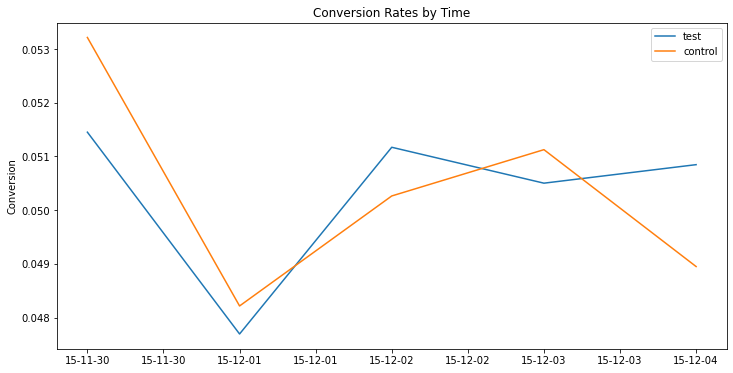

In [192]:
from matplotlib.dates import DateFormatter
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(df1[df1.test==1].groupby('date')['conversion'].mean(),label='test')
plt.plot(df1[df1.test==0].groupby('date')['conversion'].mean(),label='control')
plt.legend()
plt.title('Conversion Rates by Time')
plt.ylabel("Conversion")
date_form = DateFormatter("%y-%m-%d") #set x axis format to be year-month-day
ax.xaxis.set_major_formatter(date_form)
plt.show()

n={2*p_mean*(1-p_mean)*[(Zp - Z)^2]}/{(p1-p2)^2}  gives us appropriate sample size needed to infer with 0.8 power and 0.05 significance level:

In [193]:
def sample_power_probtest(p1, p2, power=0.8, sig=0.05):
    z = stats.norm.isf([sig/2]) #two-sided t test
    zp = -1 * stats.norm.isf([power]) 
    d = (p1-p2)
    s =2*((p1+p2) /2)*(1-((p1+p2) /2)) #p_mean: (p1+p2)/2
    n = s * ((zp + z)**2) / (d**2)
    return int(round(n[0]))

p1 = df1[df1['test']==1]['conversion'].mean()
p2 = df1[df1['test']==0]['conversion'].mean()
sample_power_probtest(p1, p2)

13600196

therefore, current sample size is too small to get meanful result for statistic significant difference, otherwise, at least 5-6 months needed for experiment if we want to get meanful inference

In [194]:
print('Conduct experiment needs about '+str(round((sample_power_probtest(p1, p2)/(len(df)/5)/30),1))+' months for biased data')
print('Conduct experiment needs about '+str(round((sample_power_probtest(p1, p2)/(len(df1)/5)/30),1))+' months for unbiased data')

Conduct experiment needs about 5.0 months for biased data
Conduct experiment needs about 6.5 months for unbiased data


show t-test value for each of the 5 days in the experiment

from below list, the t-value on each day is small, not on the rejection region>1.96 or <1.96 if alpha=0.05; and p-value>0.05(on the right), therefore, there is no statistically significant difference between the performance on non-localized translation and locialized translation

In [195]:
#on the left each list: t-test for each day of the experiment from 11.30 to 12.04 
#on the right,p-values
statistic_list = []
for date in df1.date.unique():
    dated_data = df1[df1.date == date]
    statistic = (list(stats.ttest_ind(dated_data[dated_data.test == 1].conversion,
                          dated_data[dated_data.test == 0].conversion)))
    statistic[1] = "%.5f" % statistic[1] #keep 5 decimals
    statistic_list.append(statistic)
statistic_list

[[1.4378673991518798, '0.15047'],
 [-0.39432572805503086, '0.69334'],
 [-0.926731927595662, '0.35407'],
 [0.4820453759902896, '0.62978'],
 [-0.28596493374879894, '0.77491']]

# Answer for Question 2: Are the localized translations really worse?

In [196]:
diff_test=[]
for country in np.unique(con_rate_per_group1['country']):
    control=con_rate_per_group1[con_rate_per_group1['country']==country]['sample_count'].iloc[0]
    test=con_rate_per_group1[con_rate_per_group1['country']==country]['sample_count'].iloc[1]
    diff=round(abs(test-control)/test*100,1)
    diff_test.append(diff)
print('Max difference for test: '+str(max(diff_test))+'%')

Max difference for test: 3.7%


from above line chart, in 5 days experiment, localized translation performs better than non-localized one on Dec 2nd and Dec 4th, but as  analyzed before, based on current small sample size, we are not able to inference the expected result, only if:
* keep the experiment for at least another 6 months
* keep the max difference for the 2 groups(test and control) to be 3.7%
* make the cost available during the long experiment

# Answer for Question 3: design algorithm

In [197]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350672 entries, 1 to 453320
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           350672 non-null  int64         
 1   date              350672 non-null  datetime64[ns]
 2   source            350672 non-null  object        
 3   device            350672 non-null  object        
 4   browser_language  350672 non-null  object        
 5   ads_channel       140573 non-null  object        
 6   browser           350672 non-null  object        
 7   conversion        350672 non-null  int64         
 8   test              350672 non-null  int64         
 9   sex               350218 non-null  object        
 10  age               350218 non-null  float64       
 11  country           350218 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 34.8+ MB


In [206]:
df1.isna().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         209829
browser                  0
conversion               0
test                     0
sex                      0
age                      0
country                  0
dtype: int64

convert categorical columns into numeric columns

In [204]:
# remove 454 rows from sex, as well as age and country
df1=df1.dropna(subset=['sex'])
df1.shape[0]

In [ ]:
# or impute median age to the nan
# impute = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0, copy = True)
# imputed = DataFrame(impute.fit_transform(X))
# imputed.columns = X.columns.values

In [212]:
# fillin ads_channel na to be 'no',otherwise, label code does not work
df1.ads_channel=df1.ads_channel.fillna(value='no')

In [227]:
#We are performing a numerical encoding to the categorical features, using the sklearn label encoder.
from sklearn.preprocessing import LabelEncoder
x = df1.copy()
for feature in ['browser_language', 'country', 'browser', 'ads_channel', 'device', 'source', 'sex']:
    lbl_enc = LabelEncoder()
    x[feature] = lbl_enc.fit_transform(x[feature])
    if feature == 'country':
        coun = list(lbl_enc.inverse_transform(x[feature]))
x = x.drop(['conversion','date','test','user_id'], axis = 1)
y =df1.test
x.head()

,source,device,browser_language,ads_channel,browser,sex,age,country
1,0,1,1,2,3,1,21.0,8
3,0,0,2,1,0,0,22.0,8
4,0,1,1,2,2,1,19.0,8
5,1,0,1,5,0,0,22.0,13
6,2,0,2,5,0,1,35.0,8


<AxesSubplot:xlabel='feature', ylabel='value'>

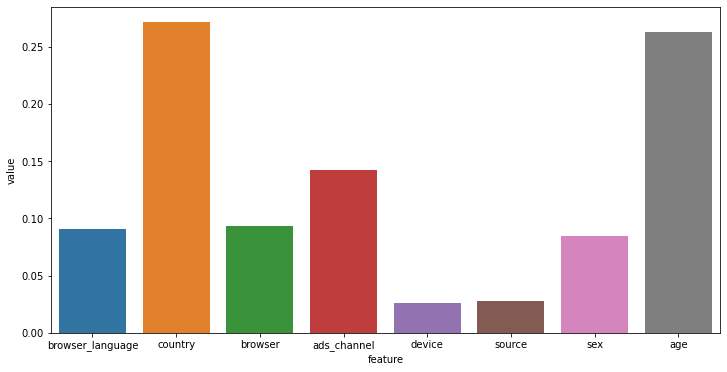

In [220]:
feature = ['browser_language', 'country', 'browser', 'ads_channel', 'device', 'source', 'sex','age']
model = DecisionTreeClassifier()
model.fit(x[feature], y)
feature_importances = model.feature_importances_
columns = ['feature', 'value']
importance = pd.DataFrame(feature_importances, index=feature).reset_index()
importance.columns = columns
plt.figure(figsize=(12,6))
sns.barplot(x='feature', y ='value', data=importance)

it seems that country and age have the maximum impact on the result.

# tune decision tree

In [233]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [5, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 20),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(x,y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 1, 'min_samples_leaf': 1}
Best score is 0.5004311643252034
